<a href="https://colab.research.google.com/github/LilySu/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/LS_DS_242_Review_and_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Practicing & Understanding Predictive Modeling_

# Review & Regularization

## Start with example solution for yesterday's assignment

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
# We'll modify a project from Python Data Science Handbook by Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic
    
# Predicting Bicycle Traffic

# As an example, let's take a look at whether we can predict the number of 
# bicycle trips across Seattle's Fremont Bridge based on weather, season, 
# and other factors.

# We will join the bike data with another dataset, and try to determine the 
# extent to which weather and seasonal factors—temperature, precipitation, 
# and daylight hours—affect the volume of bicycle traffic through this corridor. 
# Fortunately, the NOAA makes available their daily weather station data 
# (I used station ID USW00024233) and we can easily use Pandas to join 
# the two data sources.

def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

In [0]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

In [0]:
def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

In [0]:
# Download and join data into a dataframe
data = load()

#### `SNOW` and `AWND` have minimums of `-9999` ...

In [60]:
data.describe(include='number')

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2632.449671,29.350894,-37.496707,0.098777,166.863594,84.472248,22.338664,2633.056444
std,1252.864020,65.813053,612.512583,2.570041,74.779734,50.916006,307.984292,1253.138245
min,98.000000,0.000000,-9999.000000,0.000000,-16.000000,-71.000000,-9999.000000,98.000000
25%,1806.000000,0.000000,0.000000,0.000000,111.000000,44.000000,22.000000,1806.000000
50%,2435.000000,0.000000,0.000000,0.000000,150.000000,83.000000,29.000000,2435.000000
75%,3574.500000,26.500000,0.000000,0.000000,222.000000,128.000000,40.000000,3574.500000
max,6088.000000,559.000000,74.000000,80.000000,356.000000,183.000000,95.000000,6088.000000


### Clean data and engineer features

In [0]:
def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)#replace with zeros
    X = jake_wrangle(X)
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_squared'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    # DS3 JD
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.1) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)

    return X

In [0]:
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test  = wrangle(X_test)


RandomizedSearchCV review / SPRINT CHALLENGE PRACTICE
- https://twitter.com/jakevdp/status/648593367786323968
- https://www.google.com/search?q=site%3Ascikit-learn.org+RandomizedSearchCV
  - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
  - https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
- https://www.google.com/search?q=XGBRegressor
  - https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://www.google.com/search?q=xgboost+parameter+tuning
  - https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
- https://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb

In [9]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 5)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=3,#three fold cross-validation, split into 3 parts trained on 2, validate on 3rd.
    verbose=10,
    return_train_score=True
  )
search.fit(X_train, y_train)



Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdf2d01fbe0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdf21a09c88>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [11]:
print('MeanBasolute Error with Cross-Validation')
print(f' Predictions are off by: {int(-search.best_score_)} bicyclicsts per day, on average')


MeanBasolute Error with Cross-Validation
 Predictions are off by: 267 bicyclicsts per day, on average


In [14]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
31,0.261832,0.004444,0.006159,0.000221,3,148,"{'max_depth': 3, 'n_estimators': 148}",-244.082667,-305.170642,-252.558408,-267.270572,27.021855,1,-141.972687,-138.017880,-143.784820,-141.258462,2.407902
39,0.217957,0.006948,0.006100,0.000303,3,122,"{'max_depth': 3, 'n_estimators': 122}",-243.309740,-304.413538,-254.310872,-267.344717,26.593600,2,-154.573488,-148.836114,-154.090917,-152.500173,2.598360
20,0.328461,0.012796,0.006795,0.000442,2,254,"{'max_depth': 2, 'n_estimators': 254}",-241.135179,-302.486193,-259.590208,-267.737193,25.700412,3,-172.142847,-162.822325,-168.859488,-167.941553,3.860050
43,0.244432,0.005249,0.006060,0.000067,2,188,"{'max_depth': 2, 'n_estimators': 188}",-239.082574,-307.598816,-257.814950,-268.165447,28.913301,4,-185.270360,-179.129226,-183.212163,-182.537250,2.552125
27,0.362979,0.005817,0.007389,0.000228,2,287,"{'max_depth': 2, 'n_estimators': 287}",-242.176765,-303.130473,-259.213251,-268.173496,25.678177,5,-166.504423,-156.383323,-162.691492,-161.859746,4.173569


In [13]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
47,0.173427,0.005520,0.005384,0.000027,1,195,"{'max_depth': 1, 'n_estimators': 195}",-289.609868,-332.464660,-324.146799,-315.407109,18.554783,46,-271.100937,-266.770578,-266.968782,-268.280099,1.996274
19,0.170509,0.009352,0.005362,0.000059,1,196,"{'max_depth': 1, 'n_estimators': 196}",-289.576487,-332.720544,-324.038928,-315.445320,18.632230,47,-270.940645,-266.513772,-266.558630,-268.004349,2.076356
8,0.145375,0.005477,0.005174,0.000062,1,162,"{'max_depth': 1, 'n_estimators': 162}",-291.447752,-337.826983,-327.831233,-319.035322,19.929614,48,-279.447500,-273.192459,-277.136405,-276.592121,2.582450
32,0.139599,0.007627,0.005390,0.000340,1,149,"{'max_depth': 1, 'n_estimators': 149}",-293.405354,-342.035906,-328.566641,-321.335967,20.501132,49,-283.697866,-276.645941,-281.306564,-280.550123,2.928203
7,0.072436,0.001562,0.004622,0.000049,1,73,"{'max_depth': 1, 'n_estimators': 73}",-342.144237,-394.889102,-365.285755,-367.439698,21.586799,50,-341.077278,-322.373466,-334.747586,-332.732777,7.767571


In [16]:
search.best_estimator_.feature_importances_

array([0.05964509, 0.        , 0.0008556 , 0.22975464, 0.00441577,
       0.00320189, 0.06174905, 0.04187493, 0.01210303, 0.00330486,
       0.00727313, 0.01424039, 0.01287015, 0.00128582, 0.0269335 ,
       0.05477451, 0.00357982, 0.        , 0.00712386, 0.01268985,
       0.04653367, 0.00608215, 0.00229126, 0.        , 0.00393254,
       0.00355252, 0.00158259, 0.01838065, 0.        , 0.00469817,
       0.00104004, 0.        , 0.0078413 , 0.00397333, 0.00308195,
       0.00208467, 0.0091768 , 0.        , 0.32807246], dtype=float32)

In [17]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=148, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [18]:
pd.Series(search.best_estimator_.feature_importances_, X_train.columns)

PRCP               0.059645
SNOW               0.000000
SNWD               0.000856
TMAX               0.229755
TMIN               0.004416
AWND               0.003202
Total_yesterday    0.061749
Mon                0.041875
Tue                0.012103
Wed                0.003305
Thu                0.007273
Fri                0.014240
Sat                0.012870
Sun                0.001286
holiday            0.026933
daylight_hrs       0.054775
Temp (C)           0.003580
dry day            0.000000
annual             0.007124
PRCP_yesterday     0.012690
Windchill          0.046534
Rl_Cold            0.006082
TMIN_squared       0.002291
Jan                0.000000
Feb                0.003933
Mar                0.003553
Apr                0.001583
May                0.018381
Jun                0.000000
Jul                0.004698
Aug                0.001040
Sep                0.000000
Oct                0.007841
Nov                0.003973
Dec                0.003082
light_rain         0

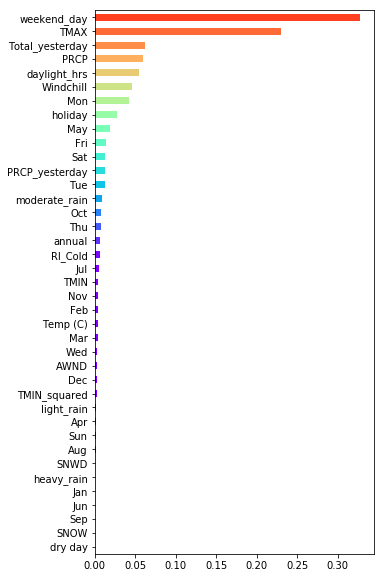

In [41]:
import random
from matplotlib.pyplot import cm
import numpy as np
plt.figure(figsize=(5,10))
importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color = iter(cm.rainbow(np.linspace(-1.1,1.5))));

Take the last step

Yesterday's assingment said,

At the end of the day, take the last step in the "universal workflow of machine learning" — "You can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set."

See the [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) documentation for the `refit` parameter, `best_estimator_` attribute, and `predict` method:

> **refit : boolean, or string, default=True**

> Refit an estimator using the best found parameters on the whole dataset.

> The refitted estimator is made available at the `best_estimator_` attribute and permits using `predict` directly on this `GridSearchCV` instance.

In [43]:
#Is it a best practice to test many random state and then take the average of the results? no, you don't want to optimize for the random state
#you don't want to ask what random state will give my model to best result, this would overfit your model to randomness
#we cross validated with train but did not use test set yesterday, test set is used once at the very end
from sklearn.metrics import mean_absolute_error
final = search.best_estimator_
y_pred = final.predict(X_test)#We already wrangled X_test in the same way as X_train
test_mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error, with final model, on the hold-out test set:', test_mae)
#the most recent 100 days used for the future
# our model is generalizing well

Mean Absolute Error, with final model, on the hold-out test set: 237.74991455078126


In [0]:
#how good will this model need to be is determined by decisionmakers.

A few new things!
- Pipeline + RandomizedSearchCV
- SelectKBest for feature selection, in a pipeline
- Ridge Regression, a linear model with regularization

In [50]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model import Ridge

ModuleNotFoundError: ignored

In [48]:
pipe = make_pipeline(
    RobustScaler(),
    SelectKBest(f_regression),
    Ridge())
#ridge regression similiar to mean squared error
para_distributions = {
    'selectkbest__k': range(1, len(X_train.columns)+1),#SelectKBest k parameter, length of values I want to try
    'ridge__alpha': [0.1, 1.0, 10.]#pipeline and hyperparameter optimization#what piece of the pipeline, the alpha class
}#I want to try different k values for my parameter and different parameters for alpha ridge pipeline

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=100,#linear regression trains faster
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True,
    random_state = 42
)

search.fit(X_train, y_train)

NameError: ignored

In [0]:
list(range(1, len(X_train.columns)+1))

In [0]:
print('Mean Absolute Error with Cross-Validation:', -search.best_score_)

In [0]:
# Shows which features were selected
selector = search.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n', 'Features not selected:')
for name in unselected_names:
    print(name)

Regularization with Linear Models

- https://www.google.com/search?q=site%3Ascikit-learn.org+regularization+%22linear+models%22
  - https://scikit-learn.org/stable/modules/linear_model.html
  - https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression
  - https://scikit-learn.org/stable/modules/linear_model.html#lasso
  - https://scikit-learn.org/stable/modules/linear_model.html#setting-regularization-parameter
  - https://scikit-learn.org/stable/modules/linear_model.html#using-cross-validation
    
> The [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. 
  
> The `alpha` parameter controls the degree of sparsity of the estimated coefficients.
  
> scikit-learn exposes objects that set the Lasso `alpha` parameter by cross-validation: [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) ...

In [51]:
#two different types of penalizations for coefficients
from ipywidgets import interact
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def plot_lasso_coefs(power=-2):
    # Make pipeline with StandardScaler and Lasso Linear Model
    alpha = 10**power
    print(f'Lasso Alpha: {alpha}')
    pipe = make_pipeline(StandardScaler(), Lasso(alpha=alpha, max_iter=100000))
    
    # Get cross-validation scores
    maes = -cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)
    print('Cross-Validated Mean Absolute Error:', maes.mean())
    
    # Get coefficients
    pipe.fit(X_train, y_train)
    coefficients = pd.Series(pipe.named_steps['lasso'].coef_, X_train.columns)
    
    # Plot coefficients
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-550,550)

interact(plot_lasso_coefs, power=(-2,2,1));
#when power is higher, the coefficients are sparser
#sometimes gives error, sometimes gives a model that is easier to explain
#we get a cross-validated mean absolute error below 300 when power is below 10
#to get a log scale is setting alpha to be 10 to the power is set to the slider

interactive(children=(IntSlider(value=-2, description='power', max=2, min=-2), Output()), _dom_classes=('widge…

In [52]:
from sklearn.linear_model import LassoCV

pipe = make_pipeline(StandardScaler(), LassoCV(cv=3))
pipe.fit(X_train, y_train)
lasso = pipe.named_steps['lassocv']
print('Lasso Linear Model, alpha value optimized with cross validation:', lasso.alpha_)

Lasso Linear Model, alpha value optimized with cross validation: 5.196217086880751


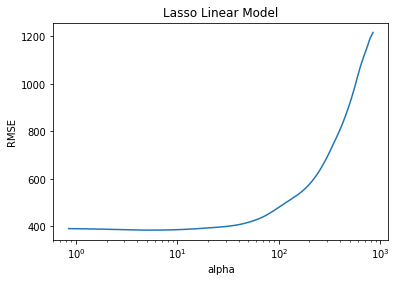

In [53]:
alphas = lasso.alphas_
mses = lasso.mse_path_.mean(axis=1)
rmses = np.sqrt(mses)
plt.plot(alphas, rmses)
plt.title('Lasso Linear Model')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.xscale('log');
#when alpha is way to high it underfits
#1 to 10 is optimal, we'll zoom in:

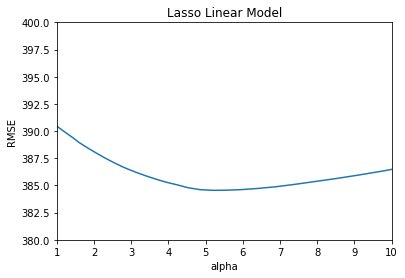

In [54]:
plt.plot(alphas, rmses)
plt.title('Lasso Linear Model')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.xlim(1,10)
plt.ylim(380,400);

Want to learn more about regularized linear models?
- Aaron Gallant, [Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) (9 minute video)
- Selecting good features, [Part 2](https://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/) and [Part 4]regularizing linear models(https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/)
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapters 3 & 6

In [0]:
#linear models, the math of linear modeling.